In [39]:
import os
import random as rnd
import sys

import h5py
import numpy as np

# import matplotlib.cm as mplcm
# import matplotlib.colors as mcolors
import torch
%matplotlib inline
from matplotlib import pyplot as plt
from skimage import color
from torch.utils.data import Dataset, DataLoader

sys.path.append('../')
from utils.transform_2d import RGBDTransform

In [45]:
class NYUDepthV2Dataset(Dataset):
    """
    Link to the dataset: https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html
    TODO
        - C x H x W
        - batch_size

    """

    __data_dir = os.path.join(os.getcwd(), os.pardir, ".data")
    __set_name = "NYUDepthDatasetV2"
    __set_file = "nyu_depth_v2_labeled.mat"

    def __init__(
        self,
        data_path=None,
        split="train",
        transform=None,
        resize=False,
        verbose=True,
        random_seed=42,
        num_samples=10,
    ):
        super().__init__()
        self.data_path = os.path.abspath(
            data_path
            if data_path
            else os.path.join(self.__data_dir, self.__set_name, self.__set_file)
        )
        self.split = split
        self.transform = transform
        self.verbose = verbose
        self.random_seed = random_seed
        rnd.seed(self.random_seed)
        self.num_samples = num_samples

        # Load the .mat f
        with h5py.File(self.data_path, "r") as f:
            # HxWx3XN -> NxHxWx3
            # HxWx3xN -> Nx3xHxW TODO
            self.rgb_images = torch.from_numpy(np.transpose(f["images"][:self.num_samples].astype(np.float16) / 255.0, (0, 3, 2, 1)))
            self.depth_maps = torch.from_numpy(np.transpose(f["depths"][:self.num_samples], (0, 2, 1)))
            self.labels = torch.from_numpy(np.transpose(f["labels"][:self.num_samples].astype(np.uint8), (0, 2, 1)))

            chr_arr = [list(f[ref][()].flatten()) for ref in f["names"][0]]
            self.class_names = ["".join(chr(c) for c in name) for name in chr_arr]
            
        if self.transform:
            if not resize:
                resize = (self.rgb_images.shape[1], self.rgb_images.shape[2])
            std, mean = torch.std_mean(self.rgb_images.reshape(-1, 3), dim=0)
            std_depth, mean_depth = torch.std_mean(self.depth_maps.reshape(-1), dim=0)
            std = std.tolist()
            mean = mean.tolist()
            std.append(std_depth.item())
            mean.append(mean_depth.item())
            self.transform = RGBDTransform(resize=resize, mean=mean, std=std)

    def __len__(self):
        return len(self.rgb_images)

    def __getitem__(self, idx):
        rgb_image = self.rgb_images[idx]
        depth_map = self.depth_maps[idx]
        label = self.labels[idx]

        sample = (rgb_image, depth_map, label)

        if self.transform:
            sample = self.transform(sample)

        return sample

    def __repr__(self) -> str:
        repr = f"""
        NYUDepthV2Dataset(split={self.split}, data_path={self.data_path})
        Number of samples: {len(self)}
        Number of labels: {len(self.class_names)}
        RGB image shape: {self.rgb_images.shape}
        Depth map shape: {self.depth_maps.shape}
        Label shape: {self.labels.shape}"""
        return repr

    def visualize_rnd_sample(self):
        rnd_idx = rnd.randint(0, len(self) - 1)
        rgb_image = self.rgb_images[rnd_idx].numpy().astype(np.float32)
        depth_map = self.depth_maps[rnd_idx]
        label = self.labels[rnd_idx]

        # Define a discrete colormap
        # unique_labels = np.unique(label)
        # num_labels = len(unique_labels)

        # color_map = color.label2rgb(label)
        # labels = [self.label_id2name(color.rgb2label(color_map)) for color in np.unique(color_map)]

        _, (ax0, ax1, ax2) = plt.subplots(
            1, 3, sharex=True, sharey=True, figsize=(18, 6)
        )
        ax0.imshow(rgb_image)
        ax0.set_title("RGB image")
        ax0.set_axis_off()
        ax1.imshow(depth_map, cmap="hot", interpolation="nearest")
        ax1.set_title("Depth map")
        ax1.set_axis_off()
        # im = ax2.imshow(label, cmap=cmap, norm=norm)
        ax2.imshow(color.label2rgb(label.numpy()))
        ax2.set_title("Ground truth")
        ax2.set_axis_off()

        # colorbar = plt.colorbar(im, ax=ax2, ticks=unique_labels)
        # colorbar.set_ticklabels([f"{id}:{self.label_id2name(id)}" for id in unique_labels])

        plt.show()

    def split_dataset(self, split=0.8):
        """Split the dataset into two parts with the specified ratio."""
        if split > 1 or split < 0:
            raise ValueError("Split ratio must be between 0 and 1.")
        num_samples = len(self)
        num_samples_train = int(num_samples * split)
        num_samples_val = num_samples - num_samples_train
        train_set, val_set = torch.utils.data.random_split(
            self,
            [num_samples_train, num_samples_val],
            generator=torch.Generator().manual_seed(self.random_seed),
        )
        return train_set, val_set

    # def get_colors(self, num_colors):
    #     cm = plt.get_cmap("gist_rainbow")
    #     c_norm = mcolors.Normalize(vmin=0, vmax=num_colors - 1)
    #     scalar_map = mplcm.ScalarMappable(norm=c_norm, cmap=cm)
    #     colors = [scalar_map.to_rgba(i) for i in range(num_colors)]
    #     return colors

    def label_name2id(self, label_name):
        return self.class_names.index(label_name)

    def label_id2name(self, label_id):
        return self.class_names[label_id]


In [46]:
dataset = NYUDepthV2Dataset(
    data_path="/Volumes/Extreme SSD/nyu_depth_v2_labeled.mat",
    transform=RGBDTransform,
    num_samples=10
)

[0.266845703125, 0.27490234375, 0.29052734375, 1.1991831064224243] [0.53662109375, 0.5107421875, 0.475830078125, 2.7613821029663086]


In [42]:
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
# print(dataloader)

train_loader, test_loader = [DataLoader(split) for split in dataset.split_dataset(split=0.8)]
# for i, data in enumerate(test_loader):
#     print(data)
#     break

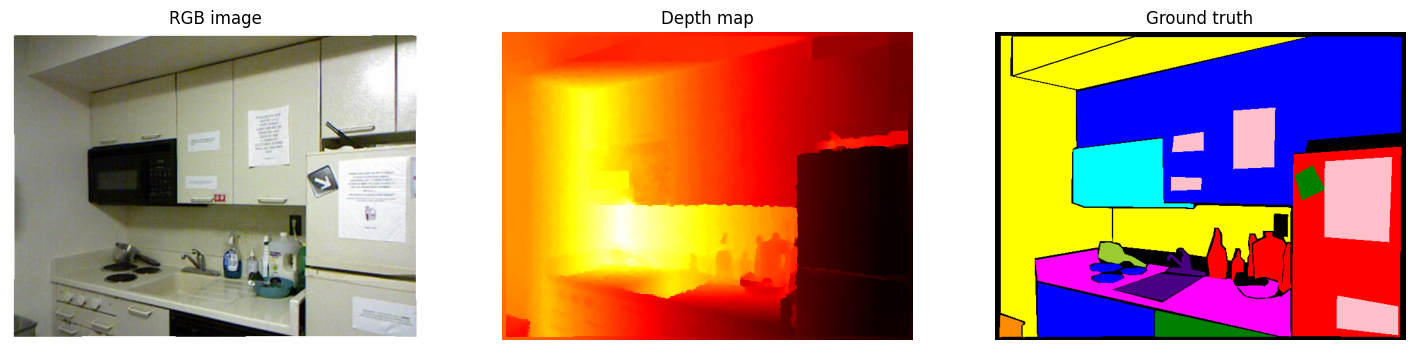


        NYUDepthV2Dataset(split=train, data_path=/Volumes/Extreme SSD/nyu_depth_v2_labeled.mat)
        Number of samples: 10
        Number of labels: 894
        RGB image shape: torch.Size([10, 480, 640, 3])
        Depth map shape: torch.Size([10, 480, 640])
        Label shape: torch.Size([10, 480, 640])


In [43]:
dataset.visualize_rnd_sample()
print(dataset)